# PyTorch Seq2Seq tutorial
My implementation of the [PyTorch tutorial on sequence-to-sequence text processing](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (in this case, for a machine translation task).


## Other helpful tutorials
* [LSTMs in PyTorch for part-of-speech tagging](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
* [Transformers in PyTorch for language modeling](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)


## Other helpful resources
* Andrej Karpathy's [GitHub repo with char-rnn](https://github.com/karpathy/char-rnn) in Lua Torch; he explains parameters like _temperature_ and _priming_.

Import required modules

In [1]:
# Other packages
import io           # process various input formats
import unicodedata  # Unicode character reference (access to database on character properties)
import string       # string constants
import re           # regular expressions
import random       # random selection methods
import os           # file management
import zipfile      # extract zip files (e.g., data file
import requests     # get information from websites (e.g., download data file)
from tqdm.notebook import tqdm  # progress bar display

# PyTorch packages
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data preprocessing

Download data, which can be found at https://download.pytorch.org/tutorial/data.zip

The data has translations of sentences between English and French.

In [29]:
# Determine the directory to save the file called 'data.zip'
url = 'https://download.pytorch.org/tutorial/data.zip'
# url = 'https://www.manythings.org/anki/spa-eng.zip'
zip_path = url[url.rfind('/')+1:]
print('.zip file will be saved in: ' + os.getcwd() + '/' + zip_path)

# Download the file
# See: https://www.kite.com/python/answers/how-to-download-a-file-from-a-url-in-python#use-requests-get
with open('./' + zip_path, mode='wb') as download:
    download.write(requests.get(url).content)

# Unzip the file
# See: https://stackoverflow.com/questions/31346790/unzip-all-zipped-files-in-a-folder-to-that-same-folder-using-python-2-7-5/56850153#56850153
zipfile.ZipFile(zip_path).extractall()

# try:
#     zipfile.ZipFile(zip_path).extractall()
# except zipfile.BadZipFile:
#     print('Problem unzipping file')

.zip file will be saved in: /content/data.zip


Create one-hot encoded vocabulary vectors, using dictionaries to track word-to-index and index-to-word representations of each word, along with a word frequency dictionary (word2count) to help with replacing rare words during translation.

In [30]:
# Start Of Sequence token
SOS_token = 0
# End Of Sequence token
EOS_token = 1


# Language class to hold vocabulary dictionaries that map words to index positions
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        # n_words has 2 at initialization: SOS and EOS
        self.n_words = 2
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word2index:
            # Assign word to the next index value
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Convert Unicode to ASCII to simplify (by reducing the character set)

In [31]:
# See: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string/518232#518232
def unicodeToAscii(s):
    return ''.join(
        char for char in unicodedata.normalize('NFD', s)
        if unicodedata.category(char) != 'Mn'
    )

def normalizeString(s):
    '''lowercase, trim, and remove non-letter characters'''
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r'([.!?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    return s

Read the file and separate into a list with each line of the file. Each line contains an English sentence followed by a translation in another language. The `reverse` flag will read other language --> English.

In [32]:
def readLang(lang1, lang2, reverse=False):
    print('Reading lines...')

    # Read file and split into lines
    lines = open(f'data/{lang1}-{lang2}.txt', encoding='utf-8').read().strip().split('\n')

    # Create and normalize pairs of strings from each line
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs and create Lang objects for them
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

Filter dataset to reduce its size and training time.

In [33]:
# Set max word length for a sentence (including ending punctuation)
MAX_LENGTH = 10

# Sentences chosen will be those that start with the following forms:
eng_prefixes = (
    'i am', 'i m',
    'he is', 'he s',
    'she is', 'she s',
    'you are', 'you re',
    'we are', 'we re',
    'they are', 'they re'
)

def filterPair(p):
    return (len(p[0].split(' ')) < MAX_LENGTH
            and len(p[1].split(' ')) < MAX_LENGTH
            and p[1].startswith(eng_prefixes))

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Create function to load and process data

In [34]:
def prepareData(lang1, lang2, reverse=False):
    # Read a text file, split into lines and then into pairs
    input_lang, output_lang, pairs = readLang(lang1, lang2, reverse=reverse)
    print(f'Read {len(pairs):,d} pairs')
    pairs = filterPairs(pairs)
    print(f'Trimmed to {len(pairs):,d} sentence pairs')
    print('Counting words...')
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print(f'Input: {input_lang.name} ({input_lang.n_words:,d} words)'
            + f', Output: {output_lang.name} ({output_lang.n_words:,d} words)')
    return input_lang, output_lang, pairs

In [35]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', reverse=True)
print(f'\nRandom pair from {input_lang.name} and {output_lang.name}: {random.choice(pairs)}')

Reading lines...
Read 135,842 pairs
Trimmed to 11,893 sentence pairs
Counting words...
Input: fra (4,920 words), Output: eng (3,228 words)

Random pair from fra and eng: ['je suis realiste .', 'i m realistic .']


## Create neural network (sequence-to-sequence)

### Encoder network
The encoder network produces a vector representing the meaning of an input. In this case, it will produce a vector output for each word in the input.

See: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-encoder

In [36]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # Vector embedding of input
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Gated Recurrent Unit
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    # Note that forward() takes two inputs: the normal 'input' and 'hidden'
    def forward(self, input, hidden):
        # Create a vector embedding of size (1, 1, *input.size())
        # which corresponds to num_in_batch, num_channels, num_dimensions_input
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    # Initialize the hidden weights with zeros
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder network
The decoder network takes an input vector (the output of the encoder network) and ouputs a vector in word-space that represents the probability distribution across words.

Each iteration of the decoder network takes an input token and a hidden vector. The first input is the start-of-string token (SOS_token, or 0), and the first hidden vector is the final output vector from the encoder network, which is called the _context_ vector.

See: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-decoder

In [37]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Model training
See: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#training

Set up functions for preparing training data. Each training pair (input, target) must include a tensor for the input where each value is the index of the word in the input sentence, and a tensor for the output where each value is the index of the ward in the target sentence.

Note that the end-of-sequence (EOS) tag is appended to the end of each vector in the training pairs.

In [38]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    # A 1-column integer vector with as many rows as there are indexes
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training loop

Plotting function

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def showPlot(losses, accuracy, titles=['Loss', 'Accuracy'], xlabels=['Samples', 'Samples'], ylabels=['Loss', 'Accuracy']):
    plt.subplot(2, 1, 1)
    plt.plot(losses)
    plt.title(titles[0])
    plt.xlabel(xlabels[0])
    plt.ylabel(ylabels[0])

    plt.subplot(2, 1, 2)
    plt.plot(accuracy)
    plt.title(titles[1])
    plt.xlabel(xlabels[1])
    plt.ylabel(ylabels[1])
    plt.tight_layout()
    plt.show()

In [40]:
# Testing a procedure for calculating accuracy between tensors

a = torch.tensor([6,4,0,122,5,12,3,1], dtype=torch.long, device=device).view(-1, 1)
b = torch.tensor([6,5,1,122,5,12,2,1], dtype=torch.long, device=device).view(-1, 1)

(a == b).sum().item() / a.size(0)

0.625

In [41]:
def train(
    input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
    decoder_optimizer, criterion, max_length=MAX_LENGTH):

    encoder_hidden = encoder.initHidden()

    # Reset gradients in the encoder and decoder networks
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad() 

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Pass data through the encoder network and store outputs
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Start loss and accuracy at 0
    loss = 0
    # Accuracy is: num_correct_outputs / total_outputs. Best is 1, worst is 0.
    acc = 0

    for encoder_input in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[encoder_input], encoder_hidden)
        encoder_outputs[encoder_input] = encoder_output[0, 0]
    
    
    # Set initial decoder input to the start-of-sequence token
    decoder_input = torch.tensor([[SOS_token]], device=device)
    # Set initial decoder hidden state to final encoder hidden state
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        # Find the maximum value and index (input?)
        topv, topi = decoder_output.topk(1)
        # Detach from history (gradient) and set as next input
        decoder_input = topi.squeeze().detach()
        # Calculate loss and accuracy (scalar values)
        loss += criterion(decoder_output, target_tensor[di])
        acc += (decoder_input == target_tensor[di]).sum().item()
        # Exit loop if end of sequence token is reached
        if decoder_input.item() == EOS_token:
            break
    
    # Backpropagate the loss
    loss.backward()

    # Step along gradient
    encoder_optimizer.step()
    decoder_optimizer.step()

    # Average the loss
    acc = acc / target_length

    # Return the average loss and accuracy per iteration
    return (loss.item() / target_length, acc)

Steps for complete training process:
1. Start timer (or `tqdm`)
2. Intialize optimizers and criterion (loss function)
3. Create a set of training pairs
4. Start (empty) list of losses for plotting over time
5. Call `train` through thousands of iterations and save loss information every so often.

In [42]:
def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=1000, learning_rate = 0.01):
    # Store loss information for plotting
    plot_losses = []
    plot_accuracy = []

    # Will be reset every print_every (or plot_every) iterations
    print_loss_total = 0
    plot_loss_total = 0
    print_acc_total = 0
    plot_acc_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    # Create a list of random samples from the dataset, equal in length to the
    # number of iterations (n_iters)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

    criterion = nn.NLLLoss()

    progress_bar = tqdm(total=n_iters)
    progress_bar.set_description('Training progress')

    # Train on selected samples
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss, acc = train(input_tensor, target_tensor, encoder, decoder,
                          encoder_optimizer, decoder_optimizer, criterion)

        print_loss_total += loss
        plot_loss_total += loss
        print_acc_total += acc
        plot_acc_total += acc
        
        # Print loss information
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_acc_avg = print_acc_total / print_every
            # Reset loss and accuracy sums
            print_loss_total = 0
            print_acc_total = 0
            progress_bar.set_description(f'Training progress: loss={print_loss_avg:,.2f}, acc={print_acc_avg:,.2f}')
        
        # Save loss information for plotting
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_acc_avg = plot_acc_total / plot_every
            # Reset loss and accuracy sums
            plot_loss_total = 0
            plot_acc_total = 0
            plot_losses.append(plot_loss_avg)
            plot_accuracy.append(plot_acc_avg)
        
        progress_bar.update(n=1)

    # showPlot(plot_losses, plot_accuracy)

    return plot_losses, plot_accuracy

## Evaluation
Follows same procedure as training, but there are no target labels -- the model's predictions are just passed right back as inputs for the next iteration.

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#evaluation

In [57]:
def eval(encoder, decoder, sentence, max_length=MAX_LENGTH):
    # Disable gradient computation
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for encoder_input in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[encoder_input], encoder_hidden)
            
            encoder_outputs[encoder_input] += encoder_output[0, 0]
        
        # Start decoder with start-of-sequence (SOS) token
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []

        # Size reference for the tensors used below
        # `````````````````````````````````````````
        # decoder_output is a tensor of size torch.Size([1, 3228])
        # decoder_output is a probability distribution across all words in the output space
        # which, for Enlish is 3,228 (see the cell above where languages are loaded for the count)
        # topvalue and topindex are tensors of size torch.Size([1, 1])
        # topvalue is the maximum value across the decoder_output tensor
        # topindex is the index (position) of the maximum value in the
        # decoder_output tensor; that is, it is the word that has the highest
        # probability.
        

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topvalue, topindex = decoder_output.data.topk(1)

            # Uncomment these lines to learn about the variables used here.
            # print(f'decoder output: {decoder_output.data}')
            # print(f'decoder output size: {decoder_output.data.shape}')
            # print(f'topvalue: {topvalue}, topindex: {topindex}')
            # print(f'topvalue size: {topvalue.shape}, topindex size: {topindex.shape}\n')
            
            if topindex.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topindex.item()])
            
            decoder_input = topindex.squeeze().detach()
        
        return decoded_words

Create function to display outputs from evaluation

In [44]:
def evalRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        output_words = eval(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print(f'Input: {pair[0]}')
        print(f'Target: {pair[1]}')
        print(f'Guess: {output_sentence}\n')

## Create and train network

In [64]:
# Set number of hidden nodes
hidden_size = 64
# Initialize networks
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

In [65]:
# Run training loop
plot_losses, plot_accuracy = trainIters(encoder1, decoder1, n_iters=1000, print_every=10, plot_every=100)

  0%|          | 0/1000 [00:00<?, ?it/s]

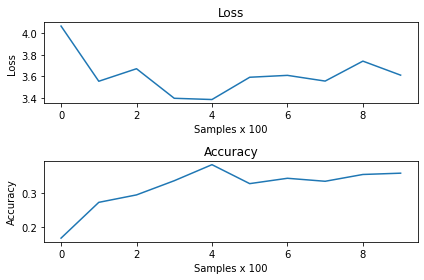

In [66]:
showPlot(plot_losses, plot_accuracy, xlabels=['Samples x 100', 'Samples x 100'])

In [67]:
evalRandomly(encoder1, decoder1, n=3)

Input: je suis fatiguee des devoirs .
Target: i am tired of homework .
Guess: i m smarter to . <EOS>

Input: elle est un peu niaise .
Target: she s a bit naive .
Guess: she s a to . <EOS>

Input: je suis heureuse moi aussi .
Target: i m happy too .
Guess: i m sure . . <EOS>



# Lab 6: Sequence-to-sequence models

### Description:
For this lab, you will replicate the [char-rnn model by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters and can be used to sample new sequences that are like the original.

This lab will help you develop several new skills and understand some best practices needed for building large models. In addition, you'll be able to create networks that generate neat text!

### Deliverable:
- Fill in the code for the RNN (using PyTorch's built-in GRU).
- Fill in the training loop
- Fill in the evaluation loop. In this loop, rather than using a validation set, you will sample text from the RNN.
- Implement your own GRU cell.
- Train your RNN on a new domain of text (Star Wars, political speeches, etc. - have fun!)

### Grading Standards:
- 20% Implementation the RNN
- 20% Implementation training loop
- 20% Implementation of evaluation loop
- 20% Implementation of your own GRU cell
- 20% Training of your RNN on a domain of your choice

### Tips:
- Read through all the helper functions, run them, and make sure you understand what they are doing
- At each stage, ask yourself: What should the dimensions of this tensor be? Should its data type be float or int? (int is called `long` in PyTorch)
- Don't apply a softmax inside the RNN if you are using an nn.CrossEntropyLoss (which already applies a softmax as part of its computation).

### Example Output:
An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


## Part 0: Readings, data loading, and high-level training

---

The PyTorch sequence-to-sequence tutorial will help you develop your understanding of the code to implement a text-generating RNN.

**Read the following**

**Done** ✅ 
* ✅ [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (You will NOT be implementing the encoder part of this tutorial.) --> See section [PyTorch Seq2Seq tutorial](#scrollTo=PyTorch_Seq2Seq_tutorial) above.
* ✅ [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [1]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz
! pip install unidecode
# ! pip install torch

import unidecode
import string
import random
import re
 
# import pdb

# string.printable returns a string of all printable ASCII characters
all_characters = string.printable
n_characters = len(all_characters)
file = unidecode.unidecode(open('./text_files/lotr.txt').read())
file_len = len(file)
print(f'\n\nfile length: {file_len:,d} characters')

--2022-02-13 00:02:51--  https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz
Resolving piazza.com (piazza.com)... 18.214.211.171, 54.156.235.193, 52.7.218.200, ...
Connecting to piazza.com (piazza.com)|18.214.211.171|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz [following]
--2022-02-13 00:02:51--  https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz
Resolving cdn-uploads.piazza.com (cdn-uploads.piazza.com)... 65.8.181.79, 65.8.181.46, 65.8.181.3, ...
Connecting to cdn-uploads.piazza.com (cdn-uploads.piazza.com)|65.8.181.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533290 (1.5M) [application/x-gzip]
Saving to: ‘./text_files.tar.gz’

./text_files.tar.gz 100%[===================>]   1.46M  --.-KB/s    in 

Define a function to sample a random section of the training text.

Returns a `chunk_len` section of sequential characters from the training text starting at a randomly-chosen index.

In [3]:
chunk_len = 300
 
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]
  
print(random_chunk())

news and no mistake. You have not told me all, no 
indeed, not by a long way. But I do not doubt that you are doing as Gandalf 
would wish. There is something very big going on, that I can see, and wha


Store character indices in a vector (`tensor`, in this case)

In [5]:
import torch

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [71]:
# Display character list with indexes
for i in range(20):
    print(f'{i*5}: {all_characters[i*5]} | {(i*5)+1}: {all_characters[(i*5)+1]}'
    + f' | {(i*5)+2}: {all_characters[(i*5)+2]} | {(i*5)+3}: {all_characters[(i*5)+3]}'
    + f' | {(i*5)+4}: {all_characters[(i*5)+4]}')

# Alternative method:
# [(i, char) for i, char in enumerate(all_characters)]

0: 0 | 1: 1 | 2: 2 | 3: 3 | 4: 4
5: 5 | 6: 6 | 7: 7 | 8: 8 | 9: 9
10: a | 11: b | 12: c | 13: d | 14: e
15: f | 16: g | 17: h | 18: i | 19: j
20: k | 21: l | 22: m | 23: n | 24: o
25: p | 26: q | 27: r | 28: s | 29: t
30: u | 31: v | 32: w | 33: x | 34: y
35: z | 36: A | 37: B | 38: C | 39: D
40: E | 41: F | 42: G | 43: H | 44: I
45: J | 46: K | 47: L | 48: M | 49: N
50: O | 51: P | 52: Q | 53: R | 54: S
55: T | 56: U | 57: V | 58: W | 59: X
60: Y | 61: Z | 62: ! | 63: " | 64: #
65: $ | 66: % | 67: & | 68: ' | 69: (
70: ) | 71: * | 72: + | 73: , | 74: -
75: . | 76: / | 77: : | 78: ; | 79: <
80: = | 81: > | 82: ? | 83: @ | 84: [
85: \ | 86: ] | 87: ^ | 88: _ | 89: `
90: { | 91: | | 92: } | 93: ~ | 94:  
95: 	 | 96: 
 | 98:  | 99: 


---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please try not to look at the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**

**DOING:**
* Create a custom GRU cell

**DONE:**


## Helpful references
* https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
* https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html
* https://blog.floydhub.com/gru-with-pytorch/
* https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be




In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        # Linear layers (weight matrices)
        # ```````````````````````````````
        # Connor (TA) said: Remember to not reuse 
        # weight and bias matrices/linear layers.
        # You can use a loop to create the weights for each layer 
        # (you'll need 6 separate [weights]), but remember to store them in 
        # an nn.ModuleList rather than a standard Python list, so PyTorch can
        # correctly find their parameters when you call model.parameters().

    
    def forward(self, inputs, hidden):
        # Each layer does the following:
        # r_t = sigmoid(W_ir*x_t + b_ir + W_hr*h_(t-1) + b_hr)
        # z_t = sigmoid(W_iz*x_t + b_iz + W_hz*h_(t-1) + b_hz)
        # n_t = tanh(W_in*x_t + b_in + r_t**(W_hn*h_(t-1) + b_hn))
        # h_(t) = (1 - z_t)**n_t + z_t**h_(t-1)
        # Where ** is hadamard product (not matrix multiplication, but elementwise multiplication)
        return outputs, hiddens
  


---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from and trying to simulate.

We now want to build an RNN model. In this section, we will use built-in PyTorch pieces to create our RNN class.


**TODO:**

**DONE:** ✅
* ✅ Create an RNN class that extends from nn.Module.



In [38]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Vector representation of input
        self.embedding = nn.Embedding(num_embeddings = input_size,
                                      embedding_dim = output_size)
        # Gated Recurrent Unit
        self.gru = nn.GRU(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = n_layers)
        # Output (linear fully-connected layer)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()


    def forward(self, input_char, hidden):
        # GRU docs: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        # Output is in the form: output, hidden_state
        # Input format is sequence_length, batch_size, input_size
        # Since this is a 1-char model, sequence_length = 1. batch_size also = 1
        output = self.embedding(input_char).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        # Output is returned in 3 dimensions: sequence_length, batch_size, probability_distribution
        # Squeeze output so there are only 2 dimensions: (1, n_characters)
        output = self.relu(self.fc(output.squeeze(dim=0)))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

The `random_training_set()` function selects a random subset of the training text and offsets that subset by 1 character to define the target set.

In [ ]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# random_training_set()

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network and sample text after training.

This function outlines how training a sequence style network goes. 

### NOTE: `decoder_optimizer`, `decoder` (RNN model), and `criterion` (loss function) will be defined below as global variables

**TODO:**

**DONE:** ✅
* ✅ Fill in the pieces.




In [50]:
def train(inp, target):
    ## initialize hidden layers, set up gradient and loss 
    decoder_optimizer.zero_grad()
    hidden = decoder.init_hidden()
    # Store each prediction, for verifying against target
    predictions = []

    # Start loss and accuracy at 0
    loss = 0
    # Accuracy is: num_correct_outputs / total_outputs. Best is 1, worst is 0.
    acc = 0
    
    # Set first input to the first character in the input set
    input_char = inp[0]

    # Run the decoder once for each character in the chunk_size (target length)
    for i in range(len(target)):
        # Set input for the iteration
        input_char = inp[i]           # <-- Teacher Forcing
        decoder_output, hidden = decoder(input_char, hidden)

        # # Set input for next iteration, the max probability from outputs
        # # Dim 0 is the batch_size (just 1), so dim 1 is the probability distribution
        # # vector across the possible output space (100-dimensions, one for each character).
        # # Calling the .detach() method removes the tensor from the computation graph.
        # input_char = decoder_output.argmax(dim=1).detach()

        # Calculate loss and accuracy (which are scalar values)
        # unsqueeze operation gives a "batch_size" dimension to the target
        loss += criterion(decoder_output, target[i].unsqueeze(0))
        predictions.append(decoder_output.argmax(dim=1).item())
    
    # Backpropagate the loss
    loss.backward()

    # Step along gradient
    decoder_optimizer.step()

    # Return the loss and accuracy per iteration
    return loss.item(), predictions

---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**

**DONE:** ✅
* ✅ Fill out the evaluate function to generate text frome a primed string


In [130]:
def sample_outputs(output, temperature):
    """Takes in a vector of unnormalized probability weights and samples a character from the distribution"""
    return torch.multinomial(torch.exp(output / temperature), 1)

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    with torch.no_grad():
        # Initialize hidden state
        hidden = decoder.init_hidden()
        # First, "prime" the sequence generation with the prime_str
        full_text = ''
        for one_char in prime_str:
            full_text += one_char
            decoder_output, hidden = decoder(char_tensor(one_char), hidden)

        inp_char = sample_outputs(decoder_output, temperature)
        for iter in range(predict_len):
            decoder_output, hidden = decoder(inp_char, hidden)
            chosen_char = sample_outputs(decoder_output, temperature)
            inp_char = chosen_char
            full_text += all_characters[chosen_char.item()]
        
    return full_text

---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---

**TODO:** 

**DONE:** ✅
* ✅ Create some cool output


Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs. These are the results, along with the prime string:

---

```
Seed string: 'G'
 
 Gandalf was decrond. 
'All have lord you. Forward the road at least walk this is stuff, and 
went to the long grey housel-winding and kindled side was a sleep pleasuring, I do long 
row hrough. In  


I:
 
 I they were not the lord of the hoomes. 
Home already well from the Elves. And he sat strength, and we 
housed out of the good of the days to the mountains from his perith. 

'Yess! Where though as if  

```
---


In [82]:
from tqdm.notebook import tqdm
n_iters = 2000
print_every = 10
plot_every = 100
hidden_size = 128
n_layers = 3
lr = 0.001
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Below is the model (`decoder`) training loop. Each epoch is a single pass through a 'chunk' of text, as defined by the `chunk_len` variable at the beginning of this lab.

In [83]:
plot_losses = []
plot_accuracy = []

input_list = []
target_list = []
prediction_list = []

print_loss_total = 0
plot_loss_total = 0

progress_bar = tqdm(total=n_iters)
progress_bar.set_description('Training progress')

for iter in range(1, n_iters+1):
    # Run training through a sequence of chunk_len characters
    inp_tensor, target_tensor = random_training_set()
    # Save output: total loss over the sequence, and predictions
    loss_, guesses = train(inp_tensor, target_tensor)
    
    input_list.extend(list(inp_tensor))
    target_list.extend(list(target_tensor))
    prediction_list.extend(guesses)
    
    print_loss_total += loss_
    plot_loss_total += loss_

    # Print loss information
    if iter % print_every == 0:
        seq_length = print_every * chunk_len
        print_loss_avg = print_loss_total / seq_length
        # Find the average accuracy over the past sequence_length number of predictions
        print_acc_avg = sum([prediction_list[i]==target_list[i] for i in range(-seq_length, 0)]) / (seq_length)
        # Reset loss and accuracy sums
        print_loss_total = 0
        progress_bar.set_description(f'Training progress: loss={print_loss_avg:,.2f}, acc={print_acc_avg:,.2f}')
    
    # Save loss information for plotting
    if iter % plot_every == 0:
        seq_length = plot_every * chunk_len
        plot_loss_avg = plot_loss_total / seq_length
        plot_acc_avg = sum([prediction_list[i]==target_list[i] for i in range(-seq_length, 0)]) / (seq_length)
        # Reset loss and accuracy sums
        plot_loss_total = 0
        plot_losses.append(plot_loss_avg)
        plot_accuracy.append(plot_acc_avg)
    
    progress_bar.update(n=1)

  0%|          | 0/2000 [00:00<?, ?it/s]

Display plots showing loss and accuracy over time

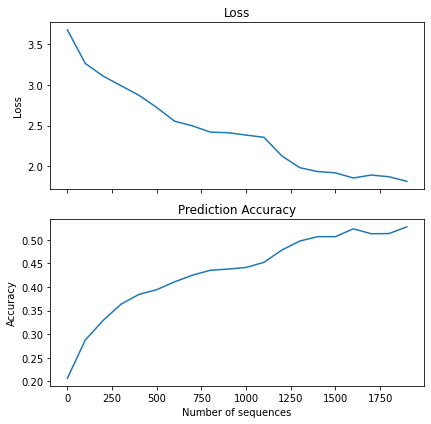

In [84]:
import matplotlib.pyplot as plt

x = range(0, n_iters, plot_every)

# for info on subplots, see: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
# and: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/shared_axis_demo.html
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 6))
ax1.plot(x, plot_losses)
ax1.set_title('Loss')
ax1.set_ylabel('Loss')

ax2.plot(x, plot_accuracy)
ax2.set_title('Prediction Accuracy')
ax2.set_xlabel('Number of sequences')
ax2.set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [85]:
start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]

for i in range(10):
    start = random.choice(start_strings)
    print(start, ':\n')
    # all_characters.index(string[c])
    print(evaluate(prime_str=start, predict_len=200, temperature=0.8), '\n\n')

 lo :

king at the plaen head 
is bent the still on the must bStill in the nees of the 
is cave had mooth out gilfor to the vidil, see there is 
But the shall still still deepaned's eep the vines Sam, and he 


 ca :

es could recearan from the 
eril like the fells then the furth the reastling illed and the looded upon in the4's 
heart startle ons book, and the cands, and speal armed before the f 


 ra :

e bour (re unders and kno}s intave the botsed stats must the rince the gate 
peaths over and in 
not remmor, and left all for as time, but 
call be an in mights gubod, and the2ll e could bent thun ea 


 ca :

e and here Lear in the have 
reallembers, and looked of 
the Fiders<ich of Zook find last to them	 had ba-ken 
that finch like the Ring fire out : But But into the feel though there dar\ not hear crun 


 ra :

hing bittle, and go that follo8s of the\ care the should hevour take the patht2ng's b$o the 
Bropslest and >or left Aronor, and had hone close of the 
denemuin Mordor e

---

## Part 6: Generate output on a different dataset

---

**TODO:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)

**DONE:**
* ✅ Chose text dataset: complete works of Jane Austen from Project Gutenberg
* ✅ Generated results (for my analysis, see below)


### Analysis
With a hidden state size of 128, 3 layers, and a sequence length of 300, the model took just under 30 minutes to train for 3,000 iterations (of 300 characters each) on Google Colab's CPUs. I did not use the GPU since I didn't think there was much to parallelize because everything was sequential and processing a single character at a time.

**What went well**

The model achieved around 60% accuracy (measured on a character-by-character basis), which is great since it has only 309,364 parameters. [Andrej Karpathy recommends](https://github.com/karpathy/char-rnn#sampling) keeping parameter count on the same order of magnitude as the input data. Since the input data I used is ~4MB, I could probably support a model with at least a couple million parameters.

**What could be improved?**

The model could be more powerful, as I noted above. I would increase the hidden state size to probably 512 and perhaps add 1 or 2 additional layers to the network. I believe if I made those adjustments and perhaps included a way to parallelize the training process so it could run on the GPU, then with a long enough training period, the model could learn to replicate Ms. Austen's writing style quite well.

**Other thoughts**

Even with a brief training period and a relatively weak model, the network successfully produced text that has a similar feel to Jane Austen's writing.



### Collect text data: all of Jane Austen's books
Source: [Project Gutenberg](https://www.gutenberg.org/ebooks/author/68)

Books included:
* [Pride and Prejudice](https://www.gutenberg.org/ebooks/1342)
* [Emma](https://www.gutenberg.org/ebooks/158)
* [Sense and Sensibility](https://www.gutenberg.org/ebooks/161)
* [Persuasion](https://www.gutenberg.org/ebooks/105)
* [Northanger Abbey](https://www.gutenberg.org/ebooks/121)
* [Mansfield Park](https://www.gutenberg.org/ebooks/141)
* [Lady Susan](https://www.gutenberg.org/ebooks/946)

In [111]:
import re        # regular expressions, for extracting text from books
import requests  # for accessing books from URLs
import os        # for creating directory to store books

book_names = [
    'Pride and Prejudice',
    'Emma',
    'Sense and Sensibility',
    'Persuasion',
    'Northanger Abbey',
    'Mansfield Park',
    'Lady Susan'
]

book_urls = [
    'https://www.gutenberg.org/files/1342/1342-0.txt',
    'https://www.gutenberg.org/cache/epub/158/pg158.txt',
    'https://www.gutenberg.org/files/161/161-0.txt',
    'https://www.gutenberg.org/cache/epub/105/pg105.txt',
    'https://www.gutenberg.org/files/121/121-0.txt',
    'https://www.gutenberg.org/files/141/141-0.txt',
    'https://www.gutenberg.org/cache/epub/946/pg946.txt'
]

# Create a folder to save the books in
try:
    os.mkdir(os.getcwd() + '/books/')
except FileExistsError:
    # folder exists, no need to create it
    pass

jane_austen_full_text = ''

# Save books to a folder so they can be accessed later if needed
# Also save the entire text in the jane_austen_full_text variable
for num, url in enumerate(book_urls):
    response = requests.get(url)
    # Ensure the response text is properly formatted as utf-8
    # See: https://stackoverflow.com/a/44203507/17005348
    response.encoding = 'UTF-8'
    book_text = response.text
    book_title = book_names[num].replace(' ', '_')
    with open(f'{os.getcwd()}/books/{book_title}.txt', mode='w+', encoding='utf-8') as book_file:
        book_file.write(book_text)
    
    # Save the text to the jane_austen_full_text variable,
    # removing the intro and end parts from Project Gutenberg
    # which have this form: *** BEGIN BOOK *** or *** END OF BOOK ***
    jane_austen_full_text += re.split(r'[*]{3}.*?[*]{3}', string=book_text)[1]

print(f'Total number of characters: {len(jane_austen_full_text):,d}')

Total number of characters: 4,296,646


Reset data loading variables (`file` is particularly crucial)

In [125]:
import unidecode

# string.printable returns a string of all printable ASCII characters
all_characters = string.printable
n_characters = len(all_characters)
# unidecode.unidecode(text_string) converts Unicode to standard ASCII characters
file = unidecode.unidecode(jane_austen_full_text)
file_len = len(file)
print(f'File length: {file_len:,d} characters')
print(f'Original text length: {len(jane_austen_full_text):,d} characters')

File length: 4,301,853 characters
Original text length: 4,296,646 characters


### Train model

In [126]:
from tqdm.notebook import tqdm
n_iters = 3000
chunk_len = 300
print_every = 10
plot_every = 100
hidden_size = 128
n_layers = 3
lr = 0.001
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [144]:
total_params = sum([layer.numel() for layer in decoder.parameters()])
print(f'{total_params:,d} parameters')

309,364 parameters


In [127]:
plot_losses = []
plot_accuracy = []

input_list = []
target_list = []
prediction_list = []

print_loss_total = 0
plot_loss_total = 0

progress_bar = tqdm(total=n_iters)
progress_bar.set_description('Training progress')

for iter in range(1, n_iters+1):
    # Run training through a sequence of chunk_len characters
    inp_tensor, target_tensor = random_training_set()
    # Save output: total loss over the sequence, and predictions
    loss_, guesses = train(inp_tensor, target_tensor)
    
    input_list.extend(list(inp_tensor))
    target_list.extend(list(target_tensor))
    prediction_list.extend(guesses)
    
    print_loss_total += loss_
    plot_loss_total += loss_

    # Print loss information
    if iter % print_every == 0:
        seq_length = print_every * chunk_len
        print_loss_avg = print_loss_total / seq_length
        # Find the average accuracy over the past sequence_length number of predictions
        print_acc_avg = sum([prediction_list[i]==target_list[i] for i in range(-seq_length, 0)]) / (seq_length)
        # Reset loss and accuracy sums
        print_loss_total = 0
        progress_bar.set_description(f'Training progress: loss={print_loss_avg:,.2f}, acc={print_acc_avg:,.2f}')
    
    # Save loss information for plotting
    if iter % plot_every == 0:
        seq_length = plot_every * chunk_len
        plot_loss_avg = plot_loss_total / seq_length
        plot_acc_avg = sum([prediction_list[i]==target_list[i] for i in range(-seq_length, 0)]) / (seq_length)
        # Reset loss and accuracy sums
        plot_loss_total = 0
        plot_losses.append(plot_loss_avg)
        plot_accuracy.append(plot_acc_avg)
    
    progress_bar.update(n=1)

  0%|          | 0/3000 [00:00<?, ?it/s]

### Plot model performance

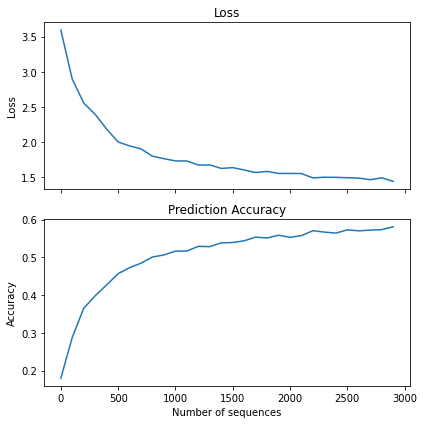

In [128]:
import matplotlib.pyplot as plt

x = range(0, n_iters, plot_every)

# for info on subplots, see: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
# and: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/shared_axis_demo.html
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 6))
ax1.plot(x, plot_losses)
ax1.set_title('Loss')
ax1.set_ylabel('Loss')

ax2.plot(x, plot_accuracy)
ax2.set_title('Prediction Accuracy')
ax2.set_xlabel('Number of sequences')
ax2.set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

### Evaluate model

In [147]:
# Generate 10-character priming sequences sampled from the text
prime_len = 10
start_locations = random.sample(range(len(file)-(prime_len+1)), k=5)
prime_sequences = [file[sl:sl+prime_len+1] for sl in start_locations]

print('Prime sequences: ', prime_sequences, '\n', '='*30, '\n', sep='')

for start in prime_sequences:
    print(evaluate(prime_str=start, predict_len=200, temperature=0.5), '\n\n')

# Alternative implementation
# for i in range(10):
#     start = random.choice(prime_sequences)
#     print(evaluate(prime_str=start, predict_len=200, temperature=0.5), '\n\n')

Prime sequences: ['a horse and', 'o her.  She', 'r dispositi', 'ducement he', 'ing got\r\nre'] 

a horse andintended to the evening the way to the
      the particulity of the way of the party. The interest could be sure in
      the fancy would be seemed prosably soon as the room.

      This was be in 


o her.  Shehad been the other was a consurced that he had
      all the particulary was particular of hope to the same could not engagement
      that the will be to the attention state to be much to the sensi 


r dispositin of the other with the world that the hanks had very inconstant of the serious of her
      pressed to the been her the things of her the saw her own
      with a with your neither to be no most co 


ducement he to the last supered to her
      to be being sentiment were the first indeed to see the handsome the
lillings a produced the every can the propicing
      conversation, and when the possible.  He  


ing got
relied she care to see the look of the family 

A second evaluation, for fun :)

In [148]:
print(evaluate(prime_str='Hello, Jane, how are you today? ', 
               predict_len=500, temperature=0.5))

Hello, Jane, how are you today? Which she was in
present to be the soon for a taken from the probormed the since. The
spread the should have in the most truth with her found the particated to be walk for
she was the fine any being a confidence of the proper, but the sister to the child on the
was the tried the confistant to all the found the room of the interious
very thing was not the ouse one was the hangs which in the father lost had been only
      the concersion of the single the satisfaction place of the sister to 


**Another potential idea for training data:** my personal, daily journal from 2021, which has 847,514 characters.